# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Stocastic Differential Equations

## Asset Price

In [3]:
class AssetPrice:
    """
    This is a class for Asset Price ODE. 
    It contains methods for finding exact solution, plotting and exat mean hitting time.
    Arguments:
    a: Lower bound
    b: Upper bound
    mu: mu
    sigma: sigma
    """
    def __init__(self, lower_b, upper_b, mu, sigma):
        self.lower_b = lower_b
        self.upper_b = upper_b
        self.mu = mu
        self.sigma = sigma
        
    def f(self,x):
        """
        Function of f(x) in asset price stochastic differential equation (deterministic part)
        """
        return self.mu * x
    
    def g(self,x):
        """
        Function of g(x) in asset price stochastic differential equation (stochastic part)
        """
        return self.sigma * x
    
    def dg(self,x):
        """
        Function of g'(x) in asset price stochastic differential equation (stochastic part)
        """
        return self.sigma
    
    def df(self,x):
        return self.mu
  

## Asset Price Interest Rate

In [4]:
class AssetPriceInterestRate:
    def __init__(self, lam, mu, sigma):
        self.lam = lam
        self.mu = mu
        self.sigma = sigma
        
    
    def f(self,x):
        return self.lam*(self.mu - x)
    
    def g(self,x):
        return self.sigma*np.sqrt(x)
    

## Opinion Polls

In [5]:
class OpinionPolls:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def f(self,x):
        return -self.mu*(x/(1-x**2))
        
    def g(self,x):
        return self.sigma

## Population Dynamic 

In [6]:
class PopulationDynamic:
    def __init__(self, K, r, beta):
        self.K = K
        self.r = r
        self.beta = beta
        
    def f(self,x):
        return self.r*x*(self.K - x)
    
    def g(self,x):
        return self.beta*x

## Epidemic Model

In [7]:
class EpidemicModel:
    
    def __init__(self, p, B, beta, alpha, rho, C):
        self.p = p
        self.B = B
        self.beta = beta
        self.alpha = alpha
        self.rho = rho 
        self.C = C
    
    def f(self, x):
        return (self.p -1)*self.B*x + (self.beta*self.C - self.alpha)*(1 - x)*x
    
    def g(self, x):
        return self.p*self.C*(1-x)*x

## Political Opinion

In [8]:
class PoliticalOpinion:
    def __init__(self, r, G, eps):
        self.r = r
        self.G = G
        self.eps = eps
        
    def f(self,x):
        return self.r*(self.G-x)
    
    def g(self,x):
        return np.sqrt(self.eps*x*(1-x))
    

## Double Well Potential

In [9]:
class DoubleWellPotential:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def f(self, x):
        return -8*x + 12*(x**2) - 4*(x**3)
    
    def g(self, x):
        return self.sigma
    
    def df(self, x):
        return -self._dV2(x)
    
    def dg(self, x):
        return 0

In [10]:
class SimpleSDE:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def f(self, x):
        return self.mu
    
    def g(self, x):
        return self.sigma
    
    def df(self, x):
        return 0
    
    def dg(self, x):
        return 0
    

## Custom SDE

In [11]:
class CustomSDE:
    def __init__(self):
        pass
    
    def f(self, x):
        return x - x**3
    
    def g(self, x):
        return np.sqrt(0.2)
    
    def df(self, x):
        return 1 - 3*(x**2)
    
    def dg(self, x):
        return 0

# Methods

## EXPONENTIAL TIMESTEPPING WITH BOUNDARY TEST FOR SDEs 

### The exponential-Euler method with boundary test (1st Algorithm)

#### Assumptions: $f(X_t) = \mu$ and $\sigma(X_t)=\epsilon$

In [12]:
class ExponentialTimestepping:
    def __init__(self, rate):
        self.rate = rate
    
    def F(self, Xn, f, g):
        return f(Xn) / g(Xn)**2
        
    def N(self, Xn,f, g):
        return np.sqrt(((2*self.rate) / (g(Xn)**2)) + self.F(Xn,f,g)**2)
    
    def udpate_time(self,Xn, f, g):
        nu2 = (2*self.rate) / g(Xn)**2
        U = f(Xn)/g(Xn)
        nu2_U2 = np.sqrt(nu2 + U**2)
        
        x = Xn
        if Xn < 0:
            x = -Xn
        return (self.rate / g(Xn)**2) * (1/nu2_U2) * np.exp(-x * nu2_U2 + U*Xn)
    
    def compute_MHT(self, X0, f, g , num_itr, lower_b=None, upper_b=None):
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -np.inf
        if upper_b is None:
            upper_b = np.inf
            
        t_exit = []
        
        for i in tqdm(range(num_itr)):
            self.breaked = 0 
            tn = 0
            Xn = X0
            temp = X0
            steps = 0
            while Xn > lower_b and Xn < upper_b:
                steps +=1
                v = np.random.uniform()
                p = -np.log(v)
                u = np.random.uniform()
                sign = np.sign(0.5*(1 + self.F(Xn,f,g)/self.N(Xn,f,g)) - u)
                Nt = self.N(Xn,f,g)
                Ft = self.F(Xn,f,g)
                
                Xn_1 = Xn + (sign*p)/(Nt-sign*Ft)
                temp = Xn_1
                dt = self.udpate_time(Xn_1, f, g)
                w = np.random.uniform()
                if Xn_1 < lower_b or w < np.exp(-2*Nt*(min(Xn, Xn_1)-lower_b)) or Xn_1 > upper_b or w < np.exp(-2*Nt*(upper_b-max(Xn, Xn_1))):
                    self.breaked += 1
                    break
                    
                tn += steps * (1/self.rate)
                steps = 0
                Xn = Xn_1
                
            t_exit.append(tn)
        
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    
    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()
    

### The exponential-V method with boundary test(2nd Algorithm)

#### Assumptions: $\sigma(x) = \epsilon$ but $f(x)$ is a function of $x$

In [13]:
class ExponentialVTimestepping:
    def __init__(self, rate):
        self.V = None
        self.rate = rate
        
    
    def nu(self,g):
        return np.sqrt(2*self.rate / g**2)
    

    def compute_MHT(self, X0, dt, f, g , num_itr, lower_b=None, upper_b=None):
        if self.V is None:
            assert("Please provide value for V")
            
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -np.inf
        if upper_b is None:
            upper_b = np.inf
            
        t_exit = []
        
        for i in tqdm(range(num_itr)):
            self.breaked = 0 
            tn = 0
            Xn = X0
            steps = 0
            while Xn > lower_b and Xn < upper_b:
                steps +=1
                nu = self.nu(g(Xn))
                print(nu)
                v = np.random.uniform()
                p = -np.log(v)
                u = np.random.uniform()
                sign = np.sign(0.5*(1 + (1/nu)*(g(Xn)**(-2))*f(Xn)) - u)
                Xn_1 = Xn + (nu**(-1))*sign*(p - (g(Xn)**(-2))*(V*(Xn + (nu**(-1))*sign*p) - V(Xn)))
                                 
                w = np.random.uniform()
                nu = self.nu(Xt, g)
                if Xn_1 < lower_b or w < np.exp(-2*nu(min(Xn, Xn_1)-lower_b)) or Xn_1 > upper_b or w < np.exp(-2*nu(upper_b - max(Xn, Xn_1))):
                    self.breaked += 1
                    break
                
            
                tn += steps * (1/self.rate)
                steps = 0
                Xn = Xn_1
                
            t_exit.append(tn)
                
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    
    
    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()
    

-----------------------------------------------------------

## Absorbing boundaries and optimal stopping in a stochastic differential equation

#### Assumtions $g(x)=\sigma$

In [14]:
class EulerMaryamaBoundaryCheck:
    def __init__(self):
        self.breaked = 0
        self.thres_coeff = 5
        pass
    
#     def P_hit(self, Xn,Xn_1,dt,bound,D, df):
#         return np.exp(-df(bound)/(2*D*(np.exp(2*dt*df(bound))-1))*(Xn_1-bound+(Xn-bound)*np.exp(dt*df(bound))-f(bound)/df(bound))**2 + (bound - (Xn + dt*(f(Xn)+f(Xn_1))/2))**2/4*D*dt)
    
    def P_hit(self, x0,xh,dt,xb,D, f_dash, f):
        return np.exp(-f_dash(xb)/(2*D*(np.exp(2*dt*f_dash(xb))-1))*(xh-xb+(x0-xb)*np.exp(dt*f_dash(xb))-f(xb)/f_dash(xb))**2 + (xb - (x0 + dt*(f(x0)+f(xh))/2))**2/4*D*dt)
    
    def compute_MHT_EM(self, X0, dt, f, g, df, num_itr, lower_b=None, upper_b=None):
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -10000
        if upper_b is None:
            upper_b = 10000
            
        t_exit = []
        
        for i in tqdm(range(num_itr)):
            self.breaked = 0 
            tn = 0
            Xn = X0
            
            while Xn > lower_b and Xn < upper_b:
                
                Rn = np.random.randn(1)
                Xn_1 = Xn + dt*f(Xn) + np.sqrt(dt)*Rn*g(Xn)
                D = (g(Xn)**2)/2 
                
                if Xn-lower_b<self.thres_coeff*dt or upper_b-Xn<self.thres_coeff*dt:
                    prob_lowerb = self.P_hit(Xn,Xn_1,dt,lower_b,D, df, f)
                    prob_upperb = self.P_hit(Xn,Xn_1,dt,upper_b,D, df, f)
                    if prob_lowerb>np.random.uniform(0,1) or prob_upperb>np.random.uniform(0,1):
                        self.breaked += 1
                        break
                        
                tn += dt
                Xn = Xn_1
            
            t_exit.append(tn-0.5*dt)
        
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    
    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()
        


    

_______________________________________

## Adaptive Timestep

In [15]:
class AdaptiveTimestep:
    def __init__(self):
        pass
    
    def naive_adaption(self, lower_b, upper_b, dt, x):
        """
        A naive method to adapt timestep based on the distance to the boundaries
        """
        epsilon = 1e-10
        dist = min(abs(x - lower_b), abs(x - upper_b))
        dt_new = (abs(np.tanh(dist))+epsilon) * dt
        return dt_new
    
    
    def adapt_time_EM(self, lower_b, upper_b, x, f, g, dt):
        min_dt = 0.0000001
        k = 1.96 # set to 1.96 for 95% credible interval of gaussian distribution
        
        f_res = f(x)
        g_res = g(x)
        
        if f_res == 0 and g(x) == 0:
            return dt
        elif g_res == 0:
            dt_new = min((upper_b-x)/f_res, (x-lower_b)/f_res)
            return min(dt, max(dt_new, min_dt))
        elif f_res == 0:
            if g_res > 0:
                dt_new = ((upper_b-x)/(k*g_res))**2
                return min(dt, max(dt_new, min_dt))
            else:
                dt_new = ((x-lower_b)/(k*g_res))**2
                return min(dt, max(dt_new, min_dt))
        elif f_res > 0:
            t1 = np.sqrt( ((upper_b-x)/f_res) + ((k*g_res)/(2*f_res))**2) - (k*g_res)/(2*f_res)
            t2 = np.sqrt( ((upper_b-x)/f_res) + ((k*g_res)/(2*f_res))**2) + (k*g_res)/(2*f_res)
            dt_new = min(t1**2, t2**2)
            return min(dt, max(dt_new, min_dt))
        
     
        t1 = np.sqrt( ((x-lower_b)/f_res) + ((k*g_res)/(2*f_res))**2) - (k*g_res)/(2*f_res)
        t2 = np.sqrt( ((x-lower_b)/f_res) + ((k*g_res)/(2*f_res))**2) + (k*g_res)/(2*f_res)
        dt_new = min(t1**2, t2**2)
        return min(dt, max(dt_new, min_dt))
    
    
    
    def _f2(self,x,f,g,dg,k):
        return f(x) + 0.5*g(x)*dg(x)*((k**2)-1)
        
    def adapt_time_Mils(self, lower_b, upper_b, x, f, g, dg, dt):
        min_dt = 0.0000001
        k = 1.96 # set to 1.96 for 95% credible interval of gaussian distribution
        
        f2_res = self._f2(x,f,g,dg,k)
        g_res = g(x)
        
        if f2_res == 0 and g_res == 0:
            return dt
        
        elif g_res == 0:
            dt_new = min((upper_b-x)/f2_res, (x-lower_b)/f2_res)
            return min(dt, max(dt_new, min_dt))
        
        elif f2_res == 0:
            if g_res > 0:
                dt_new = ((upper_b-x)/(k*g_res))**2
                return min(dt, max(dt_new, min_dt))
            else:
                dt_new = ((x-lower_b)/(k*g_res))**2
                return min(dt, max(dt_new, min_dt))
                          
        elif f2_res > 0:
            t1 = np.sqrt( ((upper_b-x)/f2_res) + ((k*g_res)/(2*f2_res))**2) - (k*g_res)/(2*f2_res)
            t2 = np.sqrt( ((upper_b-x)/f2_res) + ((k*g_res)/(2*f2_res))**2) + (k*g_res)/(2*f2_res)
            dt_new = min(t1**2, t2**2)
            return min(dt, max(dt_new, min_dt))
        
        t1 = np.sqrt( ((x-lower_b)/f2_res) + ((k*g_res)/(2*f2_res))**2) - (k*g_res)/(2*f2_res)
        t2 = np.sqrt( ((x-lower_b)/f2_res) + ((k*g_res)/(2*f2_res))**2) + (k*g_res)/(2*f2_res)
        dt_new = min(t1**2, t2**2)
        return min(dt, max(dt_new, min_dt))
    
    
    
    def compute_MHT_EM(self, X0, dt, num_itr, f, g, lower_b, upper_b):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
       
    
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -1000
        if upper_b is None:
            upper_b = 1000
            
            
        # TODO: Add threshold for situation when the loop goes forever
        t_exit = []
        
        adapt_timestep = self.adapt_time_EM
        for i in tqdm(range(num_itr)):
            X = X0
            t = 0
            while X > lower_b and X < upper_b:
                dt_new_EM = adapt_timestep(lower_b=lower_b, upper_b=upper_b, x=X, f=f, g=g, dt=dt)
                dW = np.sqrt(dt_new_EM)*np.random.randn()
                X = X + dt_new_EM*f(X) + g(X)*dW
                t += dt_new_EM

            t_exit.append(t)


        
            
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    
    
    
    def compute_MHT_Mils(self, X0, dt, num_itr, f, g, dg, lower_b, upper_b):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
        
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -1000
        if upper_b is None:
            upper_b = 1000
        
        # TODO: Add threshold for situation when the loop goes forever
        t_exit = []
        
        

        adapt_timestep = self.adapt_time_Mils
        for i in tqdm(range(num_itr)):
            X = X0
            t = 0
            # TODO: pass new dt to adapt_timestep
            while X > lower_b and X < upper_b:
                dt_new_EM = adapt_timestep(lower_b=lower_b, upper_b=upper_b, x=X, f=f, g=g, dg=dg, dt=dt)
                dW = np.sqrt(dt_new_EM)*np.random.randn()
                X = X + dt_new_EM*f(X) + g(X)*dW + 0.5 * g(X)*dg(X)*(dW**2 - dt_new_EM)
                t += dt_new_EM

            t_exit.append(t)


            
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    


    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()
        

In [16]:
from sympy.solvers.inequalities import solve_univariate_inequality
from sympy import Symbol, sin, Interval, S, sqrt
from sympy.abc import x
import sympy
x = Symbol('x')

class AdaptiveTimestep2:
    def __init__(self, zscore=0.6):
        self.zscore = zscore
        pass
    
    def find_min(self, sols):
        vals = []
        for sol in sols:
            if sol is not None:
                if sol.is_Union or sol.is_Intersection:
                    for arg in sol.args:
                        if arg.is_Interval:
                            vals.append(float(arg.args[1]))
                        elif arg.is_Union or arg.is_Intersection:
                            for a in arg.args:
                                vals.append(float(a.args[1]))
                            
                if sol.is_Interval:
                    vals.append(float(sol.args[1]))
        
        vals = [v for v in vals if str(v) != '-oo' or str(v) != 'oo']  
        
        return min(vals)
    
    def adapt_time_solver(self, upper_b, lower_b, Xn, fx, gx, dt):
        f = fx(Xn)
        g = gx(Xn)
        eps = np.arange(-self.zscore,self.zscore, 0.001)
        Xn_1dist = [Xn + f*dt + g*np.sqrt(dt)*p for p in eps]
        p_max = eps[np.argmax(Xn_1dist)]
        p_min = eps[np.argmin(Xn_1dist)]
        theta = 0.001
        
        sol1, sol2, sol3, sol4 = None, None, None, None 
        
        if (lower_b < Xn + f*dt + g*np.sqrt(dt)*p_min) and (Xn + f*dt + g*np.sqrt(dt)*p_max < upper_b):
            return dt
        
        if Xn + f*dt + g*np.sqrt(dt)*p_max > upper_b:
#             print('Upper Bound')
#             print(Xn + f*dt + g*np.sqrt(dt)*p_max)
            sol1=solve_univariate_inequality(f*x + g*p_max*sqrt(x) + Xn - upper_b < 0, x, relational=False)
            
        
        if Xn + f*dt + g*np.sqrt(dt)*p_min < lower_b:
#             print('Lower Bound')
#             print(Xn + f*dt + g*np.sqrt(dt)*p_min)
            sol2 = solve_univariate_inequality(f*x + g*p_min*sqrt(x) + Xn - lower_b > 0, x, relational=False)

#         print('SOL1: ', sol1)
#         print('SOL2: ', sol2)
        min_sol = self.find_min([sol1, sol2])
        dt_n = min(max(min_sol,theta), dt)
#         print('dt: ', dt_n)
#         print(Xn + f*dt_n + g*np.sqrt(dt_n)*p_max)
#         print('---=====---')
        return min(max(min_sol,theta), dt)
        
        
    
    def adapt_time_EM(self, upper_b, x, f, g, dt ):
        fx = f(x)
        gx = g(x)
        p = 3
        theta = 0.000001
        
        
        if fx == 0 and gx ==0:
            return dt
        
        if fx == 0 :
            return min(dt, max(((upper_b - x) / gx*p)**2, theta))
           
        temp_v = ((gx*p)/2*fx)
        root_v = np.sqrt( ((upper_b - x)/fx) + ((gx*p)/2*fx)**2 )
        
        
        if fx > 0:    
            return min(dt, max(theta, (root_v - temp_v)**2))
    
        
        if f < 0 :
            if g > 0:
                return min(dt, max(theta, (root_v + temp_v )**2, (-root_v - temp_v )**2) )
            return min(dt, max(theta, (root_v - temp_v )**2, (-root_v + temp_v )**2) )
        
        return dt
 
        
    
    def compute_MHT_EM(self, X0, dt, num_itr, f, g, lower_b, upper_b):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
        
        self.paths = []
        self.times = []
        self.timesteps = []
    
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -1000
        if upper_b is None:
            upper_b = 1000
            
            
        # TODO: Add threshold for situation when the loop goes forever
        t_exit = []
        
        
        adapt_timestep = self.adapt_time_solver
        for i in tqdm(range(num_itr)):
            X = X0
            t = 0
            path = []
            time = []
            timestep = []
            while X > lower_b and X < upper_b:
                dt_new_EM = adapt_timestep(upper_b=upper_b,lower_b=lower_b, Xn=X, fx=f, gx=g, dt=dt)
#                 print(dt_new_EM)
                dW = np.sqrt(dt_new_EM)*np.random.randn()
                X = X + dt_new_EM*f(X) + g(X)*dW
                t += dt_new_EM
                time.append(t)
                path.append(X)
                timestep.append(dt_new_EM)
            self.paths.append(path)
            self.times.append(time)
            self.timesteps.append(timestep)
#             print('-------------')
            t_exit.append(t - 0.5 * dt_new_EM)


        
            
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    


    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()
        

In [17]:
class EM_Milstein:
    def __init__(self):
        pass
    
    def compute_MHT_EM(self,X0 , dt, num_itr, f, g, lower_b, upper_b):
        
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -np.inf
        if upper_b is None:
            upper_b = np.inf
        
        t_exit = []
        for i in tqdm(range(num_itr)):
            X = X0
            t = 0
            while X > lower_b and X < upper_b:
                dW = np.sqrt(dt) * np.random.randn()
                X = X + dt*f(X) + g(X)*dW
                t += dt

            t_exit.append(t - 0.5*dt)
                
    
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)
        
        return t_exit, tmean, tstd, cileft, ciright
    
    def compute_MHT_Milstein(self, X0, dt, num_itr, f, g, dg, lower_b, upper_b):
        
        if lower_b is None and upper_b is None:
            assert("Please provide a boundary value")  
        if lower_b is None:
            lower_b = -np.inf
        if upper_b is None:
            upper_b = np.inf
        
        t_exit = []
        for i in tqdm(range(num_itr)):
            X = X0
            t = 0
            while X > lower_b and X < upper_b:
                dW = np.sqrt(dt) * np.random.randn()
                X = X + dt*f(X) + g(X)*dW + 0.5 * g(X)*dg(X)*(dW**2 - dt)
                t += dt

            t_exit.append(t - 0.5*dt)
            
        tmean = np.mean(t_exit)
        tstd = np.std(t_exit)

        cileft = tmean - 1.96*tstd/np.sqrt(num_itr)
        ciright = tmean + 1.96*tstd/np.sqrt(num_itr)

        return t_exit, tmean, tstd, cileft, ciright
    
    
    def plot(self,t_exit):
        histogram,bins = np.histogram(t_exit,bins=20,range=[0,20])
        midx = (bins[0:-1]+bins[1:])/2
        plt.bar(midx,histogram,label='Test')
        plt.show()

________________________

# Expariments

### Simulation Parametres and Mothod Instantiation

In [18]:
num_itr = int(1e1) # Number of interation for simulations
exp_rate = 10 # Lambda parameter for exponential timestepping methods E[dt] = 0.1

# Methods 
em_milstein = EM_Milstein() # Euler-maryama and Milstein method
adaptive_timestep = AdaptiveTimestep()
adaptive_timestep2 = AdaptiveTimestep2()
euler_maryama_boundary_check = EulerMaryamaBoundaryCheck()
exponentialV_timestepping = ExponentialVTimestepping(rate=exp_rate)
exponential_timestepping = ExponentialTimestepping(rate=exp_rate)

### Simple SDE: $dX = \mu dt + \sigma dW, \quad X(0) = X_0$

In [ ]:
# Parameters
mu = 0.5
sigma = 0.1
X0 = 0
lower_b = None
upper_b = 5
dt = 2


# New instance of SimpleSDE class
simpleSDE = SimpleSDE(mu = mu, sigma = sigma)
f = simpleSDE.f
g = simpleSDE.g
dg = simpleSDE.dg
df = simpleSDE.df

#### -------- RUN SIMULATION --------

#### Euler-Maruyama

In [ ]:
# Euler Maryama
t_exit_EM, tmean_EM, tstd_EM, cileft_EM, ciright_EM = em_milstein.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
print('-----Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_EM, tstd_EM, cileft_EM, ciright_EM))


#### Milstien

In [ ]:
# Misltein 
t_exit_Mils, tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils = em_milstein.compute_MHT_Milstein(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
print('-----Misltein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils))


#### EXPONENTIAL TIMESTEPPING WITH BOUNDARY TEST FOR SDEs

In [ ]:
# EXPONENTIAL TIMESTEPPING
t_exit_EM, tmean_expo_EM, tstd_expo_EM, cileft_expo_EM, ciright_expo_EM = exponential_timestepping.compute_MHT(X0=X0,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
print('-----Exponential Timestepping Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_expo_EM, tstd_expo_EM, cileft_expo_EM, ciright_expo_EM))


#### Euler-Maryama Boundary Check

#### Adaptive Timestep-Euler-Maruyama

In [ ]:
# Adaptive Euler Maryama
t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep2.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)
print('-----Adaptive Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM))


In [ ]:
paths = adaptive_timestep2.paths
times = adaptive_timestep2.times
timesteps = adaptive_timestep2.timesteps

In [ ]:
idx = np.random.randint(0,len(paths))
p = paths[idx]
t = times[idx]
ts = timesteps[idx]
print(len(p))
print(ts)
plt.figure(figsize=(10,5))

plt.plot(t, p,color='purple', label='EM-Adaptive')
plt.plot(t, ts,color='green', label='EM-Adaptive')
plt.xlabel('Time',fontsize=18)
plt.ylabel('Stock Price',fontsize=18)
plt.hlines(upper_b, xmin=0, xmax=max(t), color='red', label='Upper Bound')
plt.hlines(lower_b,xmin=0, xmax=max(t), color='blue', label='Lower Bound')

#### Adaptive Timestep-Milstein

In [ ]:
# Adaptive Milstein Maryama
t_exit_Adapt_Mils, tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils = adaptive_timestep.compute_MHT_Mils(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
print('-----Adaptive Milstein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils))


------------------------

## Asset Price: $dX = \mu X dt + \sigma X dW \qquad 0 < a < X_{0} < b$

In [19]:
# Parameters
mu = 0.1
sigma = 0.2
X0 = 1
upper_b = 2
lower_b = 0.5
dt=0.1
exact_MHT = 7.6450

# Asset Price instance
asset_price = AssetPrice(lower_b=lower_b, upper_b=upper_b, mu=mu, sigma=sigma)
f = asset_price.f
g = asset_price.g
dg = asset_price.dg
df = asset_price.df

# Run simulation


#### -------- RUN SIMULATION --------

In [ ]:
timesteps = np.linspace(0.001, 0.01, 10)    

In [ ]:
# ### test
# errors_Adaptive_EM2 = []
# for dt in timesteps:
#     t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep2.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)
#     errors_Adaptive_EM2.append(abs(tmean_Adapt_EM-exact_MHT))


In [20]:
 t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep2.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


In [21]:
tmean_Adapt_EM

6.223420505581036

In [22]:
paths = adaptive_timestep2.paths
times = adaptive_timestep2.times
timesteps = adaptive_timestep2.timesteps

86
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.021196115818770594]


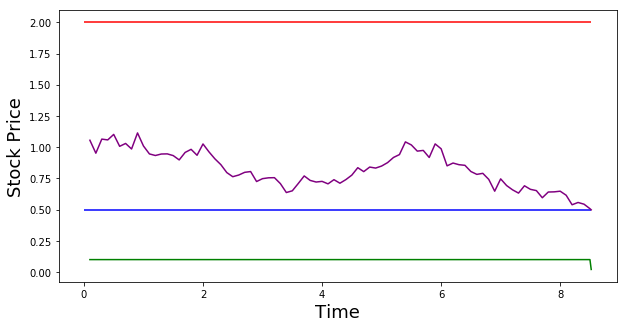

In [31]:
idx = np.random.randint(0,len(paths))
p = paths[idx]
t = times[idx]
ts = timesteps[idx]
print(len(p))
print(ts)
plt.figure(figsize=(10,5))

plt.plot(t, p,color='purple', label='EM-Adaptive')
plt.plot(t, ts,color='green', label='EM-Adaptive')
plt.xlabel('Time',fontsize=18)
plt.ylabel('Stock Price',fontsize=18)
plt.hlines(upper_b, xmin=0, xmax=max(t), color='red', label='Upper Bound')
plt.hlines(lower_b,xmin=0, xmax=max(t), color='blue', label='Lower Bound')

#### Euler-Maruyama

In [ ]:
# Euler Maryama
errors_EM = []
for dt in timesteps:
    t_exit_EM, tmean_EM, tstd_EM, cileft_EM, ciright_EM = em_milstein.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
    errors_EM.append(abs(tmean_EM - exact_MHT))

print('-----Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_EM, tstd_EM, cileft_EM, ciright_EM))


In [ ]:
errors_EM

#### Milstien

In [ ]:
# Milstein
errors_Mils = []
for dt in timesteps:
    t_exit_Mils, tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils = em_milstein.compute_MHT_Milstein(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
    errors_Mils.append(abs(tmean_Mils-exact_MHT))
    
# print('-----Misltein Method-----')
# print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils))


In [ ]:
errors_Mils

#### EXPONENTIAL-V TIMESTEPPING WITH BOUNDARY TEST FOR SDEs

#### Euler-Maryama Boundary Check

#### Adaptive Timestep-Euler-Maruyama

In [ ]:
# Adaptive Euler Maryama

errors_Adaptive_EM = []
for dt in timesteps:
    t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)
    errors_Adaptive_EM.append(abs(tmean_Adapt_EM-exact_MHT))

# print('-----Adaptive Euler Method-----')
# print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM))


In [ ]:
errors_Adaptive_EM

#### Adaptive Timestep-Milstein

In [ ]:
# Adaptive Milstein

errors_Adaptive_Mils = []
for dt in timesteps:
    t_exit_Adapt_Mils, tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils = adaptive_timestep.compute_MHT_Mils(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
    errors_Adaptive_Mils.append(abs(tmean_Adapt_Mils-exact_MHT))

# print('-----Adaptive Milstein Method-----')
# print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils))


In [ ]:
errors_Adaptive_Mils

In [ ]:
plt.loglog(timesteps, errors_EM,marker='o', label='Euler-Maryama' )
plt.loglog(timesteps, errors_Mils, marker='*', label='Milstein')
plt.loglog(timesteps, errors_Adaptive_EM, marker='+', label='Adaptive-Euler')
plt.loglog(timesteps, errors_Adaptive_Mils, marker='.', label='Adaptive-Milstein')
plt.ylabel('Error', fontsize=15)
plt.xlabel('$dt$', fontsize=15)
plt.title('Adapting Timestepping for Asset Price SDE')
plt.legend(loc='best')
plt.savefig('errors-loglog.png')

________________

### Double Well Potential

In [ ]:
# Parameters
sigma = 1
X0 = 0
lower_b = None
upper_b = 1
dt = 0.1
exact_MHT = 4.606


# New instance of SimpleSDE class
double_well_potential = DoubleWellPotential(sigma=sigma)
f = double_well_potential.f
g = double_well_potential.g
dg = double_well_potential.dg
df = double_well_potential.df

#### -------- RUN SIMULATION --------

#### Euler-Maruyama

In [ ]:
# Euler Maryama
t_exit_EM, tmean_EM, tstd_EM, cileft_EM, ciright_EM = em_milstein.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
print('-----Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_EM, tstd_EM, cileft_EM, ciright_EM))

#### Milstien

In [ ]:
# Milstein
t_exit_Mils, tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils = em_milstein.compute_MHT_Milstein(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
print('-----Misltein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils))


#### EXPONENTIAL-V TIMESTEPPING WITH BOUNDARY TEST FOR SDEs

In [ ]:
# Exponential-V timestepping
t_exit_Mils, tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils = exponentialV_timestepping.compute_MHT(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
print('-----Exponential-V Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils))


#### Euler-Maryama Boundary Check

In [ ]:
# Euler-Maryama Boundary Check
t_exit_Bound_EM, tmean_Bound_EM, tstd_Bound_EM, cileft_Bound_EM, ciright_Bound_EM = euler_maryama_boundary_check.compute_MHT(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,df = df, lower_b=lower_b,upper_b=upper_b)
print('-----Euler Method With Boundary Check-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Bound_EM, tstd_Bound_EM, cileft_Bound_EM, ciright_Bound_EM))


#### Adaptive Timestep-Euler-Maruyama

In [ ]:
# Adaptive Euler Maryama
t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)
print('-----Adaptive Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM))


#### Adaptive Timestep-Milstein

In [ ]:
# Adaptive Milstein
t_exit_Adapt_Mils, tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils = adaptive_timestep.compute_MHT_Mils(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
print('-----Adaptive Milstein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils))


---------------------------

### Opinion Poll

#### Euler-Maruyama

#### Milstien

#### EXPONENTIAL-V TIMESTEPPING WITH BOUNDARY TEST FOR SDEs

#### Euler-Maryama Boundary Check

#### Adaptive Timestep-Euler-Maruyama

#### Adaptive Timestep-Milstein

### Custom SDE: $dX = (X-X^3)dt + \sqrt{0.2}dW$

In [ ]:
# Parameters
X0 = -1
lower_b = None
upper_b = -0.5
dt = 0.1 # 0.1 - 0.001
exact_MHT = 4.555


# New instance of SimpleSDE class
custom_SDE = CustomSDE()
f = custom_SDE.f
g = custom_SDE.g
dg = custom_SDE.dg
df = custom_SDE.df

In [ ]:
timesteps = np.linspace(0.001, 0.1, 10)    

#### Euler-Maruyama

In [ ]:
# Euler Maryama

errors_EM = []
for dt in timesteps:
    t_exit_EM, tmean_EM, tstd_EM, cileft_EM, ciright_EM = em_milstein.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, lower_b=lower_b,upper_b=upper_b)
    errors_EM.append(abs(tmean_EM - exact_MHT))   
    
# print('-----Euler Method-----')
# print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_EM, tstd_EM, cileft_EM, ciright_EM))

In [ ]:
errors_EM

#### Milstien

In [ ]:
# Milstein

errors_Mils = []
for dt in timesteps:
    t_exit_Mils, tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils = em_milstein.compute_MHT_Milstein(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
    errors_Mils.append(abs(tmean_Mils - exact_MHT))
    
    
print('-----Misltein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Mils, tstd_Mils, cileft_Mils, ciright_Mils))


In [ ]:
errors_Mils

####  EXPONENTIAL-V TIMESTEPPING WITH BOUNDARY TEST FOR SDEs

#### Euler-Maryama Boundary Check

In [ ]:
# Euler-Maryama Boundary Check
errors_Bound_EM = []
for dt in timesteps:
    t_exit_Bound_EM, tmean_Bound_EM, tstd_Bound_EM, cileft_Bound_EM, ciright_Bound_EM = euler_maryama_boundary_check.compute_MHT(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,df = df, lower_b=lower_b,upper_b=upper_b)
    errors_Bound_EM.append(abs(tmean_Bound_EM - exact_MHT))
    
# print('-----Euler Method With Boundary Check-----')
# print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Bound_EM, tstd_Bound_EM, cileft_Bound_EM, ciright_Bound_EM))


In [ ]:
errors_Bound_EM

#### Adaptive Timestep-Euler-Maruyama

In [ ]:
# Adaptive Euler Maryama
errors_Adaptive_EM = []
for dt in timesteps:
    t_exit_Adapt_EM, tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM = adaptive_timestep.compute_MHT_EM(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g,lower_b=lower_b,upper_b=upper_b)
    errors_Adaptive_EM.append(abs(tmean_Adapt_EM - exact_MHT))
    
print('-----Adaptive Euler Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_EM, tstd_Adapt_EM, cileft_Adapt_EM, ciright_Adapt_EM))


In [ ]:
errors_Adaptive_EM

#### Adaptive Timestep-Milstein

In [ ]:
# Adaptive Milstein
errors_Adaptive_Mils = []
for dt in timesteps:
    t_exit_Adapt_Mils, tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils = adaptive_timestep.compute_MHT_Mils(X0=X0,dt=dt,num_itr=num_itr, f=f, g=g, dg=dg, lower_b=lower_b,upper_b=upper_b)
    errors_Adaptive_Mils.append(abs(tmean_Adapt_Mils-exact_MHT))
    
print('-----Adaptive Milstein Method-----')
print('Mean:{}, std:{}, Confidence Interval: ({},{})'.format(tmean_Adapt_Mils, tstd_Adapt_Mils, cileft_Adapt_Mils, ciright_Adapt_Mils))


In [ ]:
errors_EM=[0.09719660000005703,0.2283668000000052,0.21662539999995278,0.2532679999999967,0.2381585000000097,0.3748719999999892,0.3756169000000149,0.32637379999999183,0.4437472000000078,0.5020699999999962]

errors_Mils=[0.035453400000014845,0.1833452000000051,0.25908109999995244,0.28903259999999786,0.36226850000001143,
 0.405856799999988,
 0.4327880000000146,
 0.507013999999991,
 0.4453225000000103,
 0.5406599999999973]

errors_Adaptive_EM=[0.016711633831973494,0.0650609576277672,0.009825959994827826,0.07183287708795572,0.28791247144878884,
 0.1489495272753123,
 0.03880192733936205,
 0.18294920698114225,
 0.09212372109582656,
 0.14587050568613513]


errors_Adaptive_Mils=[0.05494701674389102,0.19804792771680546,0.07669036730320133,0.13728603174044451,
 0.16637950944741675,
 0.09914370613890355,
 0.08736576230858262,
 0.1733631024227078,
 0.19487492417158148,
 0.19215151089674087]

In [ ]:
plt.loglog(timesteps, errors_EM,marker='o', label='Euler-Maryama' )
plt.loglog(timesteps, errors_Mils, marker='*', label='Milstein')
plt.loglog(timesteps, errors_Adaptive_EM2, marker='+', label='Adaptive-Euler')
plt.loglog(timesteps, errors_Adaptive_Mils, marker='.', label='Adaptive-Milstein')
plt.ylabel('Error', fontsize=15)
plt.xlabel('$dt$', fontsize=15)
plt.title('Adapting Timestepping for Asset Price SDE')
plt.legend(loc='best')
plt.savefig('errors-loglog2.png')